In [1]:
#%matplotlib inline
import tensorflow as tf
import numpy as np
#import matplotlib.pyplot as plt
from dataset import Dataset
from model import *

from scipy.spatial.distance import cdist
from matplotlib import gridspec
from tensorflow.examples.tutorials.mnist import input_data
import pandas as  pd
import SimpleITK as sitk
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [2]:
df_info = pd.read_csv('../data/t2w/info.csv')


In [3]:
path_to_images = '../data/t2w/'
names_of_images = df_info['name']
# read images and transform to array of pixels 
images_array  = np.array([sitk.GetArrayFromImage(sitk.ReadImage(path_to_images + x )) for x  in names_of_images])

In [4]:
labels_array  = np.array([int(x) for x in df_info['ClinSig']])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(images_array, labels_array, test_size=0.33, random_state=42)

In [6]:
X_train = X_train.reshape(-1, 64, 64, 1)
X_test = X_test.reshape(-1,64,64,1)


In [7]:
dataset = Dataset()

In [8]:
dataset.images_train = X_train
dataset.images_test = X_test
dataset.labels_train = y_train
dataset.labels_test = y_test


In [9]:
#helper function to plot image
def show_image(idxs, data):
    if type(idxs) != np.ndarray:
        idxs = np.array([idxs])
    fig = plt.figure()
    gs = gridspec.GridSpec(1,len(idxs))
    for i in range(len(idxs)):
        ax = fig.add_subplot(gs[0,i])
        ax.imshow(data[idxs[i],:,:,0])
        ax.axis('off')
    plt.show()

In [10]:
train_images = dataset.images_train
test_images = dataset.images_test
len_train = len(train_images)
len_test = len(test_images)

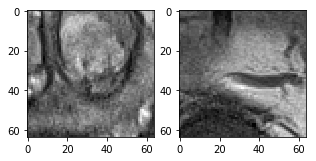

In [11]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.squeeze(train_images[1])
#curr_lbl = np.argmax(data.train.labels[0,:])
plt.imshow(curr_img, cmap='gray')
#plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

# Display the first image in testing data
plt.subplot(122)
curr_img = np.squeeze(train_images[2])
#curr_lbl = np.argmax(data.test.labels[0,:])
plt.imshow(curr_img, cmap='gray')
#plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

## Create the siamese net feature extraction model

In [12]:
img_placeholder = tf.placeholder(tf.float32, [None, 64, 64, 1], name='img')
net = mnist_model(img_placeholder, reuse=False)

## Restore from checkpoint and calc the features from all of train data

In [18]:
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    ckpt = tf.train.get_checkpoint_state("model")
    saver.restore(sess, "model/model.ckpt")
    
    a = dataset.test_oneshot(sess,net,img_placeholder,2,100)               

INFO:tensorflow:Restoring parameters from model/model.ckpt


In [19]:
a

52.0

## Searching for similar test images from trainset based on siamese feature

In [ ]:
#generate new random test image
idx = np.random.randint(0, len_test)
im = test_images[idx]

In [16]:
len(test_images)

108

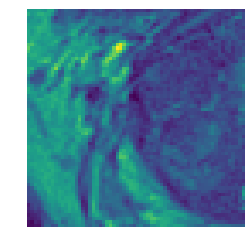

This is image from id: 21


In [17]:
#show the test image
show_image(idx, test_images)
print("This is image from id:", idx)

In [18]:
#run the test image through the network to get the test features
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    ckpt = tf.train.get_checkpoint_state("model")
    saver.restore(sess, "model/model.ckpt")
    train_feat = sess.run(net, feed_dict={img_placeholder:dataset.images_train})

INFO:tensorflow:Restoring parameters from model/model.ckpt


In [21]:
#run the test image through the network to get the test features
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    ckpt = tf.train.get_checkpoint_state("model")
    saver.restore(sess, "model/model.ckpt")
    search_feat = sess.run(net, feed_dict={img_placeholder:dataset.images_test})
    


INFO:tensorflow:Restoring parameters from model/model.ckpt


In [20]:
y_pred = np.array([])
for feat in search_feat:
    #calculate the cosine similarity and sort
    dist = cdist(train_feat, [feat], 'cosine')
    rank = np.argsort(dist.ravel())

    #show the top n similar image from train data
    y_pred = np.append(y_pred,[dataset.labels_train[rank[0]]])

NameError: name 'search_feat' is not defined

In [100]:
accuracy_score(y_pred, dataset.labels_test)

0.6666666666666666

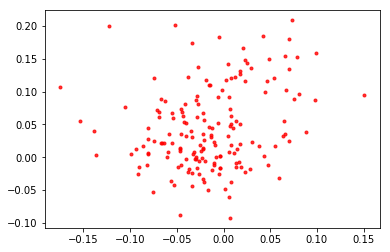

In [77]:
colors = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff', '#ff00ff', '#990000', '#999900', '#009900', '#009999']
plt.plot(search_feat[dataset.labels_train==0, 0].flatten(), search_feat[dataset.labels_train==0, 1].flatten(), '.', c=colors[0], alpha=0.8)

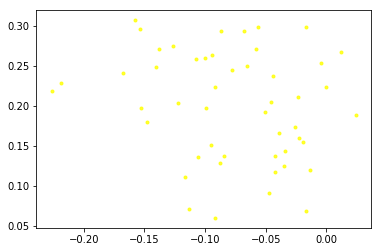

In [78]:
plt.plot(search_feat[dataset.labels_train==1, 0].flatten(), search_feat[dataset.labels_train==1, 1].flatten(), '.', c=colors[1], alpha=0.8)